### Library and model imports (execute just once)

In [1]:
from utils import list_images, generate_multichannel_tif, remap_labels, remove_border_cells, extract_features, extract_img_metadata
from cellpose import models, core
from tifffile import imread
from pathlib import Path
import numpy as np
import napari
import matplotlib.pyplot as plt

# Ignore OME-TIFF warnings during imread
import logging
logging.getLogger("tifffile").setLevel(logging.ERROR)

#Check if notebook has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

#Load pre-trained Cellpose-SAM
model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.10.18 
torch version:  	2.5.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




### Define the path containing your images

In [2]:
# Copy the path to the folder containing your images in between the quotation marks
data_folder = r"Z:\MariiaY\Evos Anna nanoparticles\Ex7_neg_LNPs_.2025-11-27-11-47-57"

# If the path is correct you should see a list of the first 10 images in your folder down below
images = list_images(data_folder, format="tif")
images[:10]

['Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f00d1.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f00d2.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f00d4.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f01d1.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f01d2.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f01d4.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f02d1.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f02d2.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.20

### Preprocess single channel into multichannel 

In [3]:
# Process single channel .tif files into multichannel .tif files and save them
generate_multichannel_tif(data_folder)


Processing input single channel .tif into multichannel .tif files 

Processed .tif files will be saved under: Z:\MariiaY\Evos Anna nanoparticles\Ex7_neg_LNPs_.2025-11-27-11-47-57\processed_tiffs



100%|██████████| 560/560 [00:01<00:00, 487.23it/s]


### Define a single image file for exploration
Just edit the number in between brackets [ ] under <code>img_filepath = processed_images[14]</code> to select the file

In [4]:
# Point to the folder containing the processed tiffs (leave by default)
processed_img_path = Path(data_folder) / "processed_tiffs"
processed_images = list_images(processed_img_path, format="tif")

# Extract experiment_id from data folder Path object
experiment_id = Path(data_folder).name

# Open any of the processed images to analyze by changing the index number in between brackets []
# index number refers to the position of the file inside the processed_images folder
# i.e. to open the first image [0], second [1] - in Python one starts counting from zero
img_filepath = processed_images[14]
img = imread(img_filepath)

### Predict nuclei and cytoplasm labels using base CellposeSAM (4.0)

In [5]:
# Extract image metadata from filename
descriptor_dict = extract_img_metadata (img_filepath, verbose = True)

# Predict nuclei labels using CellposeSAM 
nuclei_labels, flows, styles = model.eval(img[1], niter=1000) # need to check the arguments

# Predict cytoplasm labels using CellposeSAM using nuclei (1) and brightfield (2) images as input 
cytoplasm_labels, flows, styles = model.eval((img[[1,2]]), niter=1000) # need to check the arguments

# Visualize results in Napari
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(img)

# Label-to-label remapping: each nucleus inherits the cytoplasm label value it lies in
nuclei_remapped = remap_labels(nuclei_labels, cytoplasm_labels)

# Remove cell entities touching the image border
cytoplasm_labels, nuclei_remapped = remove_border_cells(cytoplasm_labels, nuclei_remapped) 
viewer.add_labels(cytoplasm_labels, opacity=0.5)
viewer.add_labels(nuclei_remapped, name="nuclei_labels", opacity=0.8)

props_df = extract_features(img, nuclei_remapped, cytoplasm_labels, descriptor_dict, scikit_props=["label", "intensity_mean", "area"])
props_df


Visualizing well: B01, FOV: 14


,well_id,FOV,label,nuclei_intensity_mean,nuclei_area,cytoplasm_intensity_mean,cytoplasm_area,cyto_to_nuclei_ratio
0,B01,14,12,14.186975,476.0,14.106195,1695.0,3.560924
1,B01,14,13,14.048980,245.0,13.903650,685.0,2.795918
2,B01,14,14,14.153558,267.0,14.123469,980.0,3.670412
3,B01,14,15,14.291228,285.0,14.295888,1362.0,4.778947
4,B01,14,16,14.326154,650.0,14.334691,1228.0,1.889231
...,...,...,...,...,...,...,...,...
529,B01,14,572,14.432353,340.0,14.388550,1310.0,3.852941
530,B01,14,573,14.088123,783.0,14.071577,1439.0,1.837803
531,B01,14,574,14.351474,882.0,14.306731,1441.0,1.633787
532,B01,14,575,14.186301,365.0,14.174283,941.0,2.578082


### Sanity check of generated label areas and threshold selection

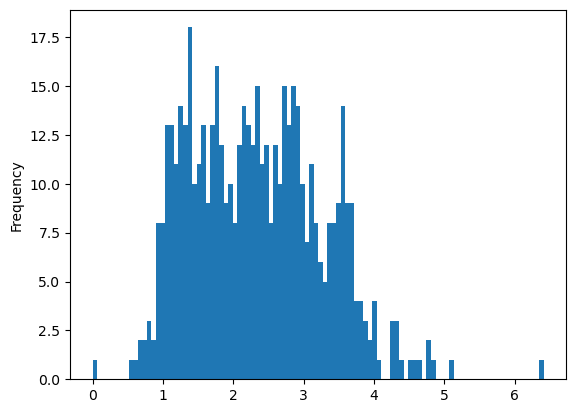

    well_id FOV  label  nuclei_intensity_mean  nuclei_area  \
273     B01  14    300              14.524017       1832.0   

     cytoplasm_intensity_mean  cytoplasm_area  cyto_to_nuclei_ratio  
273                 14.527473          2002.0              1.092795  


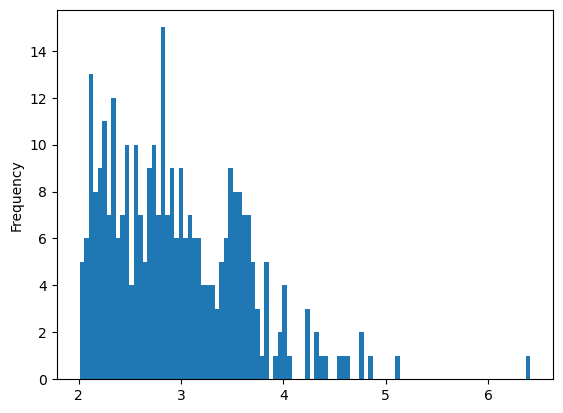

In [6]:

props_df["cyto_to_nuclei_ratio"].dropna().plot.hist(bins=100)
plt.show()

# Check individual area values to set a logical threshold
print(props_df[props_df["label"] == 300])

# Filter out labels with a cytoplasm to nuclei ratio smaller than 2
# These are cells with either incorrect nuclei segmentation or very clustered together
props_df = props_df[props_df["cyto_to_nuclei_ratio"] >= 2]


props_df["cyto_to_nuclei_ratio"].dropna().plot.hist(bins=100)
plt.show()


### Visual inspection of nuclei and cytoplasm labels after filtering

In [7]:
# Collect valid labels
valid_labels = props_df["label"].values

# Mask nuclei_labels: keep only valid labels (according to cytoplasm to nuclei ratio)
nuclei_labels_filtered = nuclei_remapped.copy()
nuclei_labels_filtered[~np.isin(nuclei_labels_filtered, valid_labels)] = 0

# Mask cytoplasm_labels: keep only valid labels (according to cytoplasm to nuclei ratio)
cytoplasm_labels_filtered = cytoplasm_labels.copy()
cytoplasm_labels_filtered[~np.isin(cytoplasm_labels_filtered, valid_labels)] = 0

viewer.add_labels(nuclei_labels_filtered)
viewer.add_labels(cytoplasm_labels_filtered)

<Labels layer 'cytoplasm_labels_filtered' at 0x298e1f65060>